# importing required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn import preprocessing
import seaborn as sn
import pickle
from sklearn.metrics import confusion_matrix

/home/fml-pc/miniconda3/envs/flwr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Converting into one hot

In [3]:
def convert_to_onehot(labels,num_classes):
    output = np.eye(num_classes)[np.array(labels).reshape(-1)]
    return output.reshape(list(np.shape(labels))+[num_classes])

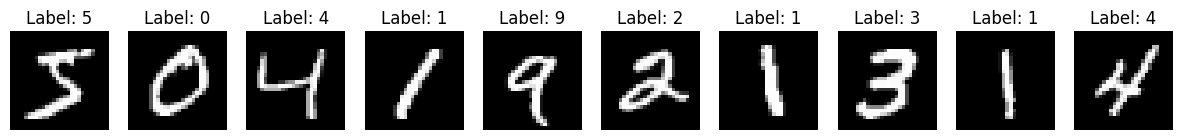

In [4]:
# Displaying first 10 trainset images
num_samples = 10

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    image, label = train_dataset[i]
    image = image.squeeze()  # Remove the single channel dimension
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


# Activation function and derivaties

SIgmoid, ReLu,Tanh

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def tanh(x):
    y=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return y

In [6]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1- sigmoid(x))

def relu_derivative(x):
    return x>0

def softmax_derivative(x):
    return softmax(x)*(1-softmax(x))

def tanh_derivative(x):
    y=tanh(x)
    return (1-y**2)

# Weight intilisation with GLOROT intilisation

In [7]:
def initialize_weights(No,Ni):
    M=np.sqrt(6/(Ni+No))
    weights=np.asarray(np.random.uniform(-M, M, (No, Ni)), dtype=np.float64)
    biases  = np.zeros((No,1))
    return weights,biases

In [8]:
def initialize_parameters(layers_dims):
    parameters = {}
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)], parameters['b' + str(l)] = initialize_weights(layers_dims[l],layers_dims[l-1])
    return parameters

# Forward pass

In [9]:
def linear_activation_forward(A_prev, W, b, activation):

    Z = np.dot(W,A_prev) + b
    cache = (A_prev, W, b)
    linear_cache = A_prev, W, b

    if activation == "sigmoid":
        A = sigmoid(Z) # This "activation_cache" contains "Z"

    elif activation == "relu":
        A = relu(Z) # This "activation_cache" contains "Z"

    elif activation == "tanh":
        A = tanh(Z) # This "activation_cache" contains "Z"

    elif activation == "softmax":
        A = softmax(Z) # This "activation_cache" contains "Z"

    activation_cache = Z
    cache = (linear_cache, activation_cache)

    return A, cache


In [10]:
def forward_propagation(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)
    return AL, caches

# Cross entropy loss


In [11]:
def compute_cost(AL, Y):    #A=cal,y=true
    m = Y.shape[1]
    cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))
    return cost

# Back propagation

In [12]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db

In [13]:
def linear_activation_backward(dZ, dA, cache, activation):

    linear_cache, activation_cache = cache
    Z = activation_cache
    if activation == "relu":
        dZ = np.multiply(dA, relu_derivative(Z))

    elif activation == "sigmoid":
        dZ = np.multiply(dA, sigmoid_derivative(Z))

    elif activation == "tanh":
        dZ = np.multiply(dA, tanh_derivative(Z))

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [14]:
def compute_grads(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = AL - Y
    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, dAL, current_cache, "softmax")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward((dAL - Y), grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

# weight updates

In [15]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

# Model

In [16]:
input_size = 784 # 28x28
layers_dim = [784,500,250,100,10]
num_classes = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.01

# Model Training

In [17]:
def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    # Add annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')

In [19]:
def evaluate(trained_parameters, plot=False):
    p=len(test_dataset)

    # # Load the parameters from the file
    # with open('model_parameters.pkl', 'rb') as f:
    #     parameters = pickle.load(f)

    loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = p ,shuffle=True)
    dataiter = iter(loader)
    data = next(dataiter)
    X,y = data

    X=X.numpy()
    y=y.numpy()
    # Flatten the images
    image_vector_size = 28*28
    X = X.reshape(X.shape[0], image_vector_size)
    y_one_hot=convert_to_onehot(y,10)
    y_pred,cache=forward_propagation(X.T,trained_parameters)
    # cost=compute_cost(y_pred,y_one_hot.T)

    test_accuracy=find_accuracy(y_one_hot,y_pred)
    test_cost=compute_cost(y_pred,y_one_hot.T)

    if plot:
        predicted = np.argmax(y_pred, axis=0)
        cm = confusion_matrix(y, predicted)
        classes = [str(i) for i in range(10)]
        # Plot confusion matrix
        plot_confusion_matrix(cm, classes)
        # plt.show()  


    return test_accuracy, test_cost

In [20]:
def model1(dataset,layers_dims,num_epochs):
    m=len(dataset)
    num_batches=m/batch_size
    parameters=initialize_parameters(layers_dims)
    costs=[]
    test_cost = []
    test_acc = []
    acc=[]
    for epoch in range(num_epochs):

        for i in range(int(num_batches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batch_size ,shuffle=True)
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            # Flatten the images
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)
            y_one_hot=convert_to_onehot(y,10)
            y_pred,cache=forward_propagation(X.T,parameters)
            cost=compute_cost(y_pred,y_one_hot.T)
            gradients=compute_grads(y_pred, y_one_hot.T,cache)
            parameters=update_parameters(parameters,gradients,learning_rate)
            if i%200==0:
                test_accuracy, test_loss = evaluate(parameters)
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{int(num_batches)}], Train Loss: {cost.item():.4f}, Test Loss {test_loss:.4f}, Train Accuracy {find_accuracy(y_one_hot,y_pred)*100:.2f} %, Test Accuracy {test_accuracy*100:.2f} %')
                costs.append(cost)
                acc.append(find_accuracy(y_one_hot,y_pred))
                # with open('model_parameters.pkl', 'wb') as f:
                #     pickle.dump(parameters, f)
                test_cost.append(test_loss)
                test_acc.append(test_accuracy)


    
    return acc,costs,test_acc, test_cost, parameters

In [21]:
def predict(X,Y,parameters):
    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

# Testing the model

In [22]:
layers_dims=[784,500,250,100,10]
train_acc,train_costs,test_acc, test_costs, trained_parameters=model1(train_dataset,layers_dims,num_epochs)

Epoch [1/15], Step [1/937], Train Loss: 3.2855, Test Loss 3.2807, Train Accuracy 4.69 %, Test Accuracy 8.64 %
Epoch [1/15], Step [201/937], Train Loss: 1.8672, Test Loss 1.7178, Train Accuracy 75.00 %, Test Accuracy 77.67 %
Epoch [1/15], Step [401/937], Train Loss: 1.2282, Test Loss 0.9795, Train Accuracy 78.12 %, Test Accuracy 85.05 %
Epoch [1/15], Step [601/937], Train Loss: 0.8438, Test Loss 0.7486, Train Accuracy 89.06 %, Test Accuracy 88.37 %
Epoch [1/15], Step [801/937], Train Loss: 0.5871, Test Loss 0.6420, Train Accuracy 90.62 %, Test Accuracy 89.81 %
Epoch [2/15], Step [1/937], Train Loss: 0.9342, Test Loss 0.5960, Train Accuracy 84.38 %, Test Accuracy 90.06 %
Epoch [2/15], Step [201/937], Train Loss: 0.4957, Test Loss 0.5574, Train Accuracy 90.62 %, Test Accuracy 90.59 %
Epoch [2/15], Step [401/937], Train Loss: 0.6264, Test Loss 0.5237, Train Accuracy 87.50 %, Test Accuracy 91.07 %
Epoch [2/15], Step [601/937], Train Loss: 0.5229, Test Loss 0.5023, Train Accuracy 90.62 %, Te

#PLots

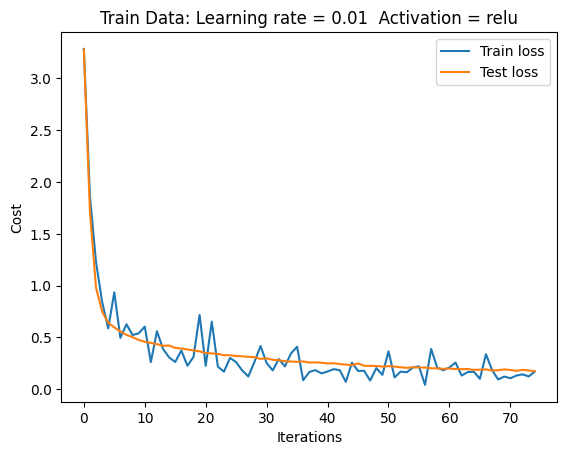

In [26]:
plt.plot(train_costs, label='Train loss')  # Adding label for training cost
plt.plot(test_costs, label='Test loss')    # Adding label for test cost
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title("Train Data: Learning rate = "  + str(learning_rate) + "  Activation = relu")
plt.legend()  # This adds the legend to the plot
plt.show()


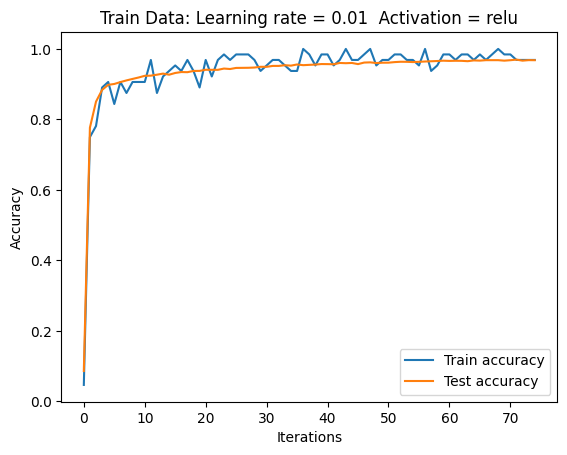

In [27]:
plt.plot(train_acc, label='Train accuracy')  # Adding label for training cost
plt.plot(test_acc, label='Test accuracy')    # Adding label for test cost
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title("Train Data: Learning rate = "  + str(learning_rate) + "  Activation = relu")
plt.legend()  # This adds the legend to the plot
plt.show()

(0.969, 0.17472074328626927)

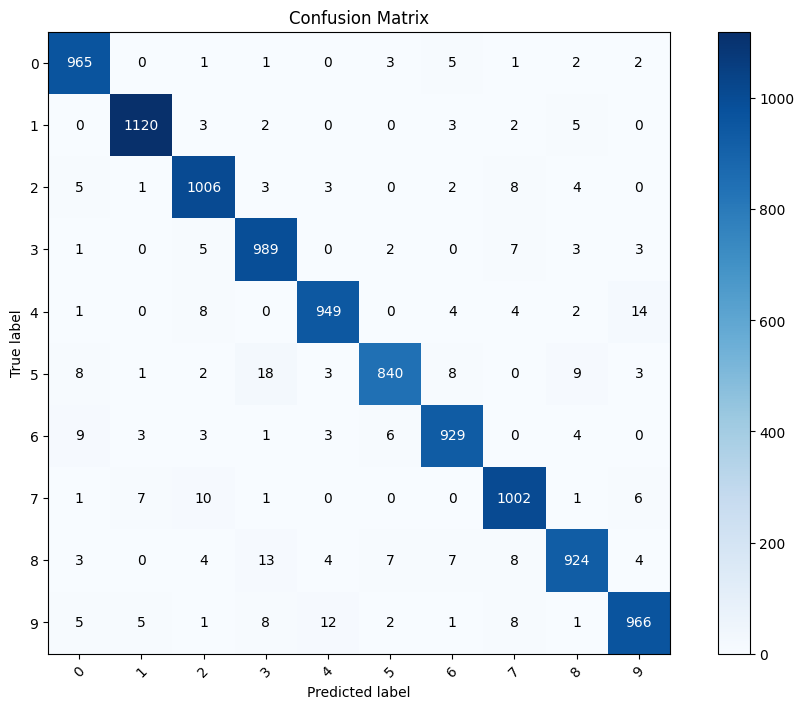

In [28]:
evaluate(trained_parameters, plot=True)